# 2D-CNN pipeline (images ready)

In [1]:
# =============================================
# ====== 1. Imports & Setup ======
# =============================================
import os, random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import iqr
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# =============================================
# ====== 2. Google Drive Mount & Paths ======
# =============================================
from google.colab import drive
drive.mount('/content/drive/')

# # Unzip if needed
# !unzip /content/CR.zip -d /content/CR


Mounted at /content/drive/


In [7]:
# base = os.path.join(base_path, "CR_16_snake_auto_scale")
base = "CR_16_snake_auto_scale"
IMG_DIR = "/content/drive/MyDrive/Spectra2Image/IMGs/CR_16_snake_auto_scale"
CSV_PATH = "/content/drive/MyDrive/Spectra2Image/target_train_488.csv"

In [8]:
# =============================================
# ====== 3. Configurations ======
# =============================================
TARGETS = ['Moi', 'NDF', 'Starch']
IMG_SIZE = 16
batch_size = 50
epochs = 200
lr = 0.0001
n_splits = 5
seed = 42
plot_name = "CR"

# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [9]:
# =============================================
# ====== 4. Data Loading & Scaling ======
# =============================================
df = pd.read_csv(CSV_PATH)
print("Data shape:", df.shape)

# Scale targets
y_scaler = StandardScaler()   # Auto-scale
targets_scaled = y_scaler.fit_transform(df[TARGETS].values.astype(np.float32))

Data shape: (488, 3)


In [10]:
# =============================================
# ====== 5. Dataset Class ======
# =============================================
class SoilImageDataset(Dataset):
    def __init__(self, df, img_dir, targets_scaled, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.targets = targets_scaled.astype(np.float32)
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{plot_name}_{idx}.png")
        if not os.path.exists(img_path):
          raise FileNotFoundError(f"Image not found: {img_path}")
        img = Image.open(img_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
        img = self.transform(img)
        target = torch.from_numpy(self.targets[idx])
        return img, target

transform = transforms.Compose([transforms.ToTensor()])
dataset = SoilImageDataset(df, IMG_DIR, targets_scaled, transform)
print("Dataset length:", len(dataset))

Dataset length: 488


In [11]:
# # ====== CNN model (as in Table 2) ======
# class CNN2D(nn.Module):
#     def __init__(self, in_channels=1, num_outputs=3): # Changed num_outputs to 3
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
#         self.pool = nn.MaxPool2d(2,2)
#         self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
#         self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
#         self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
#         self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
#         self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
#         self.conv5a = nn.Conv2d(512, 512, 3, padding=1)
#         self.conv5b = nn.Conv2d(512, 512, 3, padding=1)

#         self.flattened = 512 * 2 * 2
#         self.fc1 = nn.Linear(self.flattened, 128)
#         self.fc2 = nn.Linear(128, num_outputs)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.conv1(x)); x = self.pool(x)
#         x = self.relu(self.conv2(x)); x = self.pool(x)
#         x = self.relu(self.conv3a(x)); x = self.relu(self.conv3b(x)); x = self.pool(x)
#         x = self.relu(self.conv4a(x)); x = self.relu(self.conv4b(x)); x = self.pool(x)
#         x = self.relu(self.conv5a(x)); x = self.relu(self.conv5b(x)); x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = self.relu(self.fc1(x))
#         return self.fc2(x)

**16*16 2D CNN**

In [12]:
# =============================================
# ====== 6. CNN Model (16x16 Input) ======
# =============================================
class CNN2D(nn.Module):
    def __init__(self, in_channels=1, num_outputs=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
        self.flattened = 512 * 1 * 1
        self.fc1 = nn.Linear(self.flattened, 128)
        self.fc2 = nn.Linear(128, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x)); x = self.pool(x)  # 16→8
        x = self.relu(self.conv2(x)); x = self.pool(x)  # 8→4
        x = self.relu(self.conv3a(x)); x = self.relu(self.conv3b(x)); x = self.pool(x)  # 4→2
        x = self.relu(self.conv4a(x)); x = self.relu(self.conv4b(x)); x = self.pool(x)  # 2→1
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)


In [13]:
# =============================================
# ====== 7. Metrics Function ======
# =============================================
def compute_metrics_orig(y_true, y_pred):
    results = []
    for i in range(y_true.shape[1]):
        yt, yp = y_true[:, i], y_pred[:, i]
        rmse = np.sqrt(mean_squared_error(yt, yp))
        r2 = r2_score(yt, yp)
        bias = np.mean(yp - yt)
        results.append({"RMSE": rmse, "R2": r2, "Bias": bias})
    return results

In [14]:
# =============================================
# ====== 8. Data Split ======
# =============================================
indices = np.arange(len(dataset))
trainval_idx, test_idx = train_test_split(indices, test_size=0.25, random_state=seed)

In [ ]:
# =============================================
# ====== Print Dataset Split Sizes ======
# =============================================
print("\nDataset Split Sizes:")
print(f"Train+Validation set size: {len(trainval_idx)}")
print(f"Test set size: {len(test_idx)}")


========== Fold 1/5 ==========


Training Fold 1:   5%|▌         | 10/200 [01:19<05:50,  1.84s/it]

Epoch 10/200 | Train Loss: 0.9862 | Val Loss: 1.0063


Training Fold 1:  10%|█         | 20/200 [01:29<03:06,  1.04s/it]

Epoch 20/200 | Train Loss: 0.8965 | Val Loss: 0.8951


Training Fold 1:  15%|█▌        | 30/200 [01:39<03:05,  1.09s/it]

Epoch 30/200 | Train Loss: 0.8673 | Val Loss: 0.9034


Training Fold 1:  18%|█▊        | 36/200 [01:46<08:06,  2.97s/it]


🛑 Early Stopping at epoch 37 (no improvement for 15 epochs)

Fold Results:
Moi: RMSE=4.901, R2=0.397, Bias=-1.061


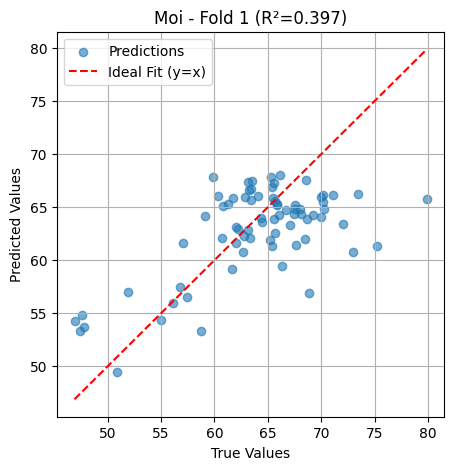

NDF: RMSE=5.478, R2=-0.041, Bias=-0.774


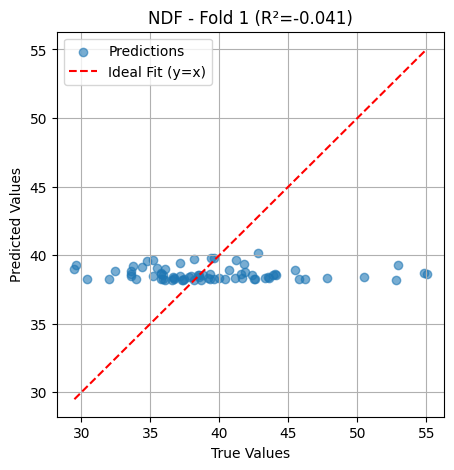

Starch: RMSE=8.817, R2=-0.039, Bias=1.333


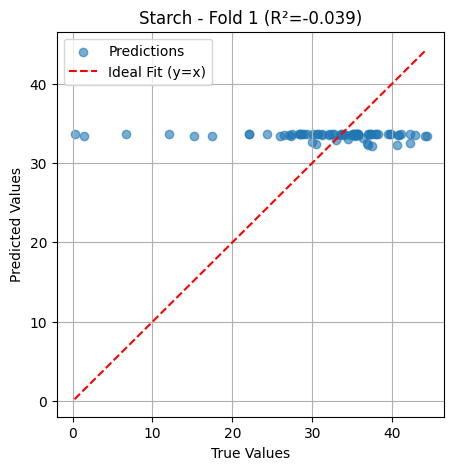


========== Fold 2/5 ==========


Training Fold 2:   5%|▌         | 10/200 [00:10<03:09,  1.00it/s]

Epoch 10/200 | Train Loss: 0.9783 | Val Loss: 1.0341


Training Fold 2:  10%|█         | 20/200 [00:20<03:11,  1.06s/it]

Epoch 20/200 | Train Loss: 0.8921 | Val Loss: 0.9507


Training Fold 2:  15%|█▌        | 30/200 [00:29<02:41,  1.05it/s]

Epoch 30/200 | Train Loss: 0.8607 | Val Loss: 0.9234


Training Fold 2:  20%|██        | 40/200 [00:40<02:35,  1.03it/s]

Epoch 40/200 | Train Loss: 0.8763 | Val Loss: 0.9132


Training Fold 2:  25%|██▌       | 50/200 [00:50<02:34,  1.03s/it]

Epoch 50/200 | Train Loss: 0.8565 | Val Loss: 0.8769


Training Fold 2:  30%|███       | 60/200 [01:00<02:19,  1.00it/s]

Epoch 60/200 | Train Loss: 0.8093 | Val Loss: 0.8410


Training Fold 2:  35%|███▌      | 70/200 [01:09<02:03,  1.05it/s]

Epoch 70/200 | Train Loss: 0.8009 | Val Loss: 0.7878


Training Fold 2:  40%|████      | 80/200 [01:20<01:58,  1.02it/s]

Epoch 80/200 | Train Loss: 0.6897 | Val Loss: 0.6923


Training Fold 2:  45%|████▌     | 90/200 [01:30<01:56,  1.06s/it]

Epoch 90/200 | Train Loss: 0.6445 | Val Loss: 0.6416


Training Fold 2:  50%|█████     | 100/200 [01:39<01:37,  1.03it/s]

Epoch 100/200 | Train Loss: 0.5870 | Val Loss: 0.6049


Training Fold 2:  55%|█████▌    | 110/200 [01:50<01:27,  1.02it/s]

Epoch 110/200 | Train Loss: 0.5881 | Val Loss: 0.5637


Training Fold 2:  60%|██████    | 120/200 [02:00<01:19,  1.01it/s]

Epoch 120/200 | Train Loss: 0.5530 | Val Loss: 0.6074


Training Fold 2:  65%|██████▌   | 130/200 [02:10<01:13,  1.05s/it]

Epoch 130/200 | Train Loss: 0.5212 | Val Loss: 0.5577


Training Fold 2:  70%|███████   | 140/200 [02:19<00:57,  1.04it/s]

Epoch 140/200 | Train Loss: 0.5997 | Val Loss: 0.6082


Training Fold 2:  75%|███████▌  | 150/200 [02:30<00:48,  1.03it/s]

Epoch 150/200 | Train Loss: 0.5421 | Val Loss: 0.5743


Training Fold 2:  80%|████████  | 160/200 [02:40<00:40,  1.02s/it]

Epoch 160/200 | Train Loss: 0.5453 | Val Loss: 0.5793


Training Fold 2:  85%|████████▌ | 170/200 [02:50<00:30,  1.01s/it]

Epoch 170/200 | Train Loss: 0.5007 | Val Loss: 0.5882


Training Fold 2:  90%|█████████ | 180/200 [03:00<00:19,  1.04it/s]

Epoch 180/200 | Train Loss: 0.5291 | Val Loss: 0.5862


Training Fold 2:  95%|█████████▌| 190/200 [03:10<00:09,  1.01it/s]

Epoch 190/200 | Train Loss: 0.4770 | Val Loss: 0.5432


Training Fold 2: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]

Epoch 200/200 | Train Loss: 0.5020 | Val Loss: 0.5917

Fold Results:
Moi: RMSE=3.297, R2=0.738, Bias=1.061


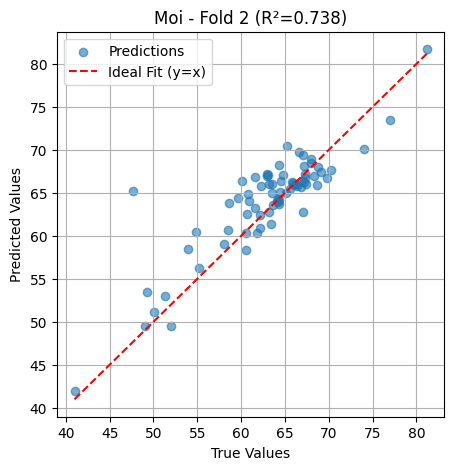

NDF: RMSE=4.687, R2=0.257, Bias=1.156


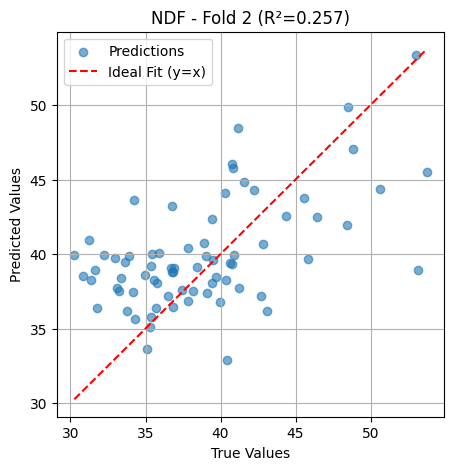

Starch: RMSE=7.416, R2=0.277, Bias=-1.102


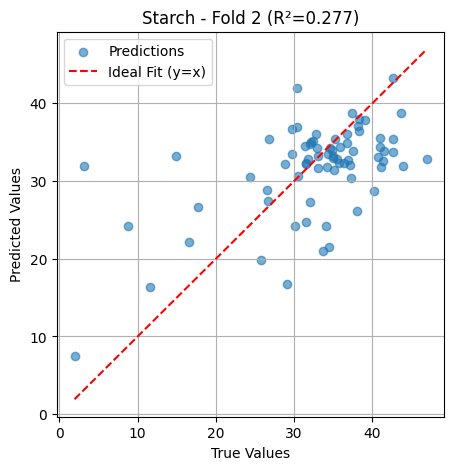


========== Fold 3/5 ==========


Training Fold 3:   5%|▌         | 10/200 [00:09<03:09,  1.00it/s]

Epoch 10/200 | Train Loss: 0.9088 | Val Loss: 1.1596


Training Fold 3:  10%|█         | 20/200 [00:19<02:51,  1.05it/s]

Epoch 20/200 | Train Loss: 0.8197 | Val Loss: 1.0848


Training Fold 3:  15%|█▌        | 30/200 [00:29<02:49,  1.00it/s]

Epoch 30/200 | Train Loss: 0.8017 | Val Loss: 1.0665


Training Fold 3:  20%|██        | 40/200 [00:39<02:52,  1.08s/it]

Epoch 40/200 | Train Loss: 0.7899 | Val Loss: 1.0549


Training Fold 3:  25%|██▌       | 50/200 [00:49<02:22,  1.05it/s]

Epoch 50/200 | Train Loss: 0.7598 | Val Loss: 1.0283


Training Fold 3:  30%|███       | 60/200 [00:59<02:17,  1.02it/s]

Epoch 60/200 | Train Loss: 0.7388 | Val Loss: 1.0126


Training Fold 3:  35%|███▌      | 70/200 [01:09<02:09,  1.00it/s]

Epoch 70/200 | Train Loss: 0.6539 | Val Loss: 0.8732


Training Fold 3:  40%|████      | 80/200 [01:19<02:02,  1.02s/it]

Epoch 80/200 | Train Loss: 0.5547 | Val Loss: 0.8043


Training Fold 3:  45%|████▌     | 90/200 [01:29<01:46,  1.04it/s]

Epoch 90/200 | Train Loss: 0.5272 | Val Loss: 0.7257


Training Fold 3:  50%|█████     | 100/200 [01:39<01:35,  1.04it/s]

Epoch 100/200 | Train Loss: 0.5362 | Val Loss: 0.7457


Training Fold 3:  55%|█████▌    | 110/200 [01:49<01:33,  1.04s/it]

Epoch 110/200 | Train Loss: 0.5282 | Val Loss: 0.6716


Training Fold 3:  60%|██████    | 120/200 [01:58<01:20,  1.00s/it]

Epoch 120/200 | Train Loss: 0.5279 | Val Loss: 0.6746


Training Fold 3:  62%|██████▎   | 125/200 [02:04<01:14,  1.00it/s]


🛑 Early Stopping at epoch 126 (no improvement for 15 epochs)

Fold Results:
Moi: RMSE=2.461, R2=0.804, Bias=0.801


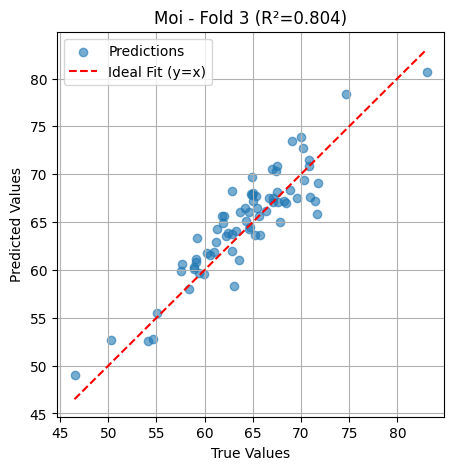

NDF: RMSE=7.236, R2=0.139, Bias=-1.034


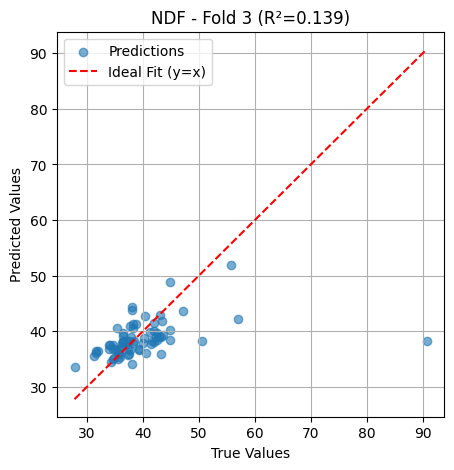

Starch: RMSE=7.132, R2=0.303, Bias=0.499


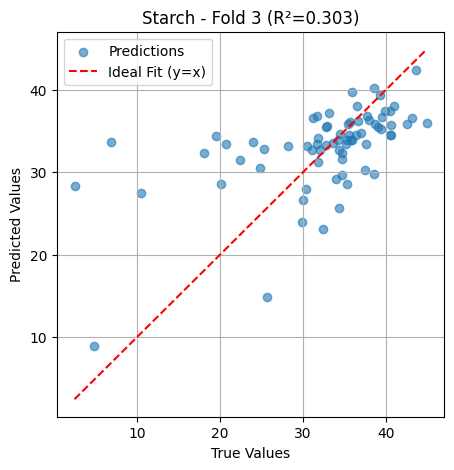


========== Fold 4/5 ==========


Training Fold 4:   5%|▌         | 10/200 [00:10<03:22,  1.07s/it]

Epoch 10/200 | Train Loss: 1.0100 | Val Loss: 0.9445


Training Fold 4:  10%|█         | 20/200 [00:19<02:51,  1.05it/s]

Epoch 20/200 | Train Loss: 0.9104 | Val Loss: 0.8731


Training Fold 4:  15%|█▌        | 30/200 [00:29<02:45,  1.03it/s]

Epoch 30/200 | Train Loss: 0.8947 | Val Loss: 0.8618


Training Fold 4:  20%|██        | 40/200 [00:41<02:42,  1.01s/it]

Epoch 40/200 | Train Loss: 0.8901 | Val Loss: 0.8591


Training Fold 4:  25%|██▌       | 50/200 [00:51<02:35,  1.04s/it]

Epoch 50/200 | Train Loss: 0.8684 | Val Loss: 0.8386


Training Fold 4:  30%|███       | 60/200 [01:01<02:24,  1.03s/it]

Epoch 60/200 | Train Loss: 0.8492 | Val Loss: 0.8120


Training Fold 4:  35%|███▌      | 70/200 [01:13<02:42,  1.25s/it]

Epoch 70/200 | Train Loss: 0.7656 | Val Loss: 0.7417


Training Fold 4:  40%|████      | 80/200 [01:27<02:19,  1.16s/it]

Epoch 80/200 | Train Loss: 0.6625 | Val Loss: 0.6865


Training Fold 4:  45%|████▌     | 90/200 [01:38<01:55,  1.05s/it]

Epoch 90/200 | Train Loss: 0.6003 | Val Loss: 0.5956


Training Fold 4:  50%|█████     | 100/200 [01:49<01:55,  1.15s/it]

Epoch 100/200 | Train Loss: 0.5944 | Val Loss: 0.5882


Training Fold 4:  55%|█████▌    | 110/200 [01:59<01:32,  1.03s/it]

Epoch 110/200 | Train Loss: 0.5840 | Val Loss: 0.5724


Training Fold 4:  60%|██████    | 120/200 [02:09<01:18,  1.03it/s]

Epoch 120/200 | Train Loss: 0.5899 | Val Loss: 0.5674


Training Fold 4:  65%|██████▌   | 130/200 [02:19<01:10,  1.00s/it]

Epoch 130/200 | Train Loss: 0.5471 | Val Loss: 0.5695


Training Fold 4:  70%|███████   | 140/200 [02:30<01:01,  1.02s/it]

Epoch 140/200 | Train Loss: 0.5393 | Val Loss: 0.5411


Training Fold 4:  75%|███████▌  | 150/200 [02:40<00:55,  1.12s/it]

Epoch 150/200 | Train Loss: 0.5594 | Val Loss: 0.5348


Training Fold 4:  80%|████████  | 160/200 [02:50<00:38,  1.04it/s]

Epoch 160/200 | Train Loss: 0.5105 | Val Loss: 0.5289


Training Fold 4:  85%|████████▌ | 170/200 [03:00<00:29,  1.03it/s]

Epoch 170/200 | Train Loss: 0.5225 | Val Loss: 0.5396


Training Fold 4:  90%|█████████ | 180/200 [03:12<00:26,  1.32s/it]

Epoch 180/200 | Train Loss: 0.5627 | Val Loss: 0.6646


Training Fold 4:  94%|█████████▎| 187/200 [03:25<00:14,  1.10s/it]


🛑 Early Stopping at epoch 188 (no improvement for 15 epochs)



Fold Results:
Moi: RMSE=3.005, R2=0.745, Bias=0.803


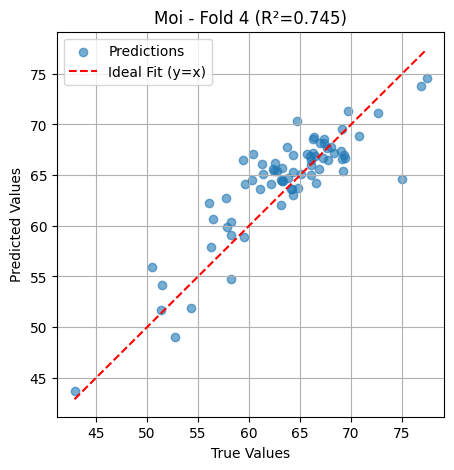

NDF: RMSE=4.454, R2=0.261, Bias=0.498


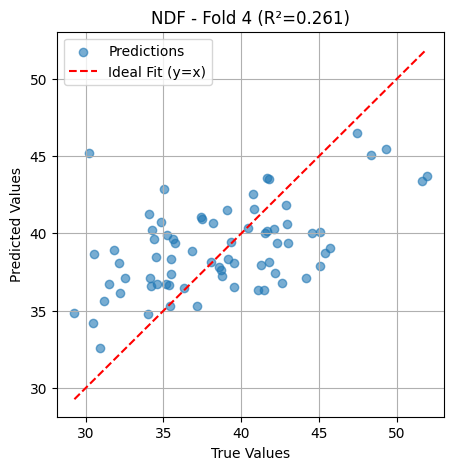

Starch: RMSE=7.333, R2=0.211, Bias=-0.840


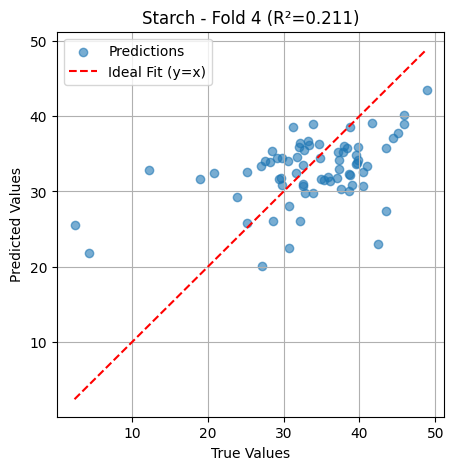


========== Fold 5/5 ==========


Training Fold 5:   5%|▌         | 10/200 [00:10<03:19,  1.05s/it]

Epoch 10/200 | Train Loss: 1.0243 | Val Loss: 0.8424


Training Fold 5:  10%|█         | 20/200 [00:21<03:01,  1.01s/it]

Epoch 20/200 | Train Loss: 0.9463 | Val Loss: 0.7195


Training Fold 5:  15%|█▌        | 30/200 [00:32<03:06,  1.10s/it]

Epoch 30/200 | Train Loss: 0.9246 | Val Loss: 0.7367


Training Fold 5:  20%|██        | 40/200 [00:44<02:47,  1.04s/it]

Epoch 40/200 | Train Loss: 0.9225 | Val Loss: 0.7225


Training Fold 5:  25%|██▌       | 50/200 [00:55<02:40,  1.07s/it]

Epoch 50/200 | Train Loss: 0.9042 | Val Loss: 0.6898


Training Fold 5:  30%|███       | 60/200 [01:06<02:59,  1.28s/it]

Epoch 60/200 | Train Loss: 0.8734 | Val Loss: 0.6637


Training Fold 5:  35%|███▌      | 70/200 [01:19<02:36,  1.20s/it]

Epoch 70/200 | Train Loss: 0.8829 | Val Loss: 0.6330


Training Fold 5:  40%|████      | 80/200 [01:30<02:00,  1.00s/it]

Epoch 80/200 | Train Loss: 0.7851 | Val Loss: 0.6017


Training Fold 5:  45%|████▌     | 90/200 [01:40<01:49,  1.00it/s]

Epoch 90/200 | Train Loss: 0.6782 | Val Loss: 0.5129


Training Fold 5:  50%|█████     | 100/200 [01:50<01:48,  1.09s/it]

Epoch 100/200 | Train Loss: 0.6190 | Val Loss: 0.3847


Training Fold 5:  54%|█████▍    | 108/200 [01:59<01:41,  1.10s/it]


🛑 Early Stopping at epoch 109 (no improvement for 15 epochs)

Fold Results:
Moi: RMSE=2.781, R2=0.809, Bias=-0.723


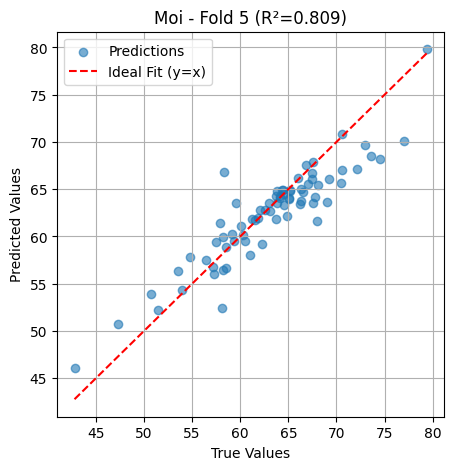

NDF: RMSE=4.160, R2=0.256, Bias=0.611


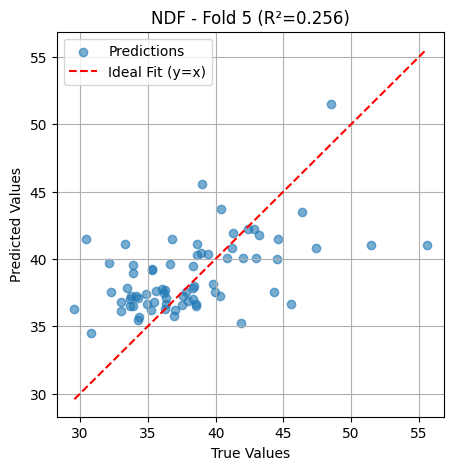

Starch: RMSE=6.012, R2=0.257, Bias=-1.154


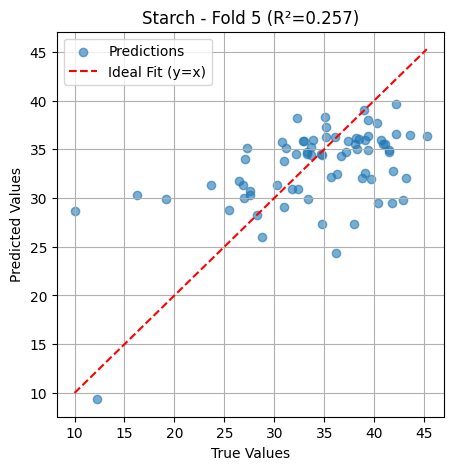



===== 📊 Average Results Across All Folds =====
Moi: Avg RMSE=3.289, Avg R2=0.699, Avg Bias=0.176
NDF: Avg RMSE=5.203, Avg R2=0.175, Avg Bias=0.091
Starch: Avg RMSE=7.342, Avg R2=0.202, Avg Bias=-0.253


In [15]:
# =============================================
# ====== 9. 5-Fold Cross Validation ======
# =============================================
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

# To store results for all folds
fold_metrics = {t: {'RMSE': [], 'R2': [], 'Bias': []} for t in TARGETS}

for fold, (t_idx, v_idx) in enumerate(kf.split(np.arange(len(trainval_idx)))):
    print(f"\n========== Fold {fold + 1}/{n_splits} ==========")

    # DataLoaders
    train_loader = DataLoader(Subset(dataset, trainval_idx[t_idx]), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(Subset(dataset, trainval_idx[v_idx]), batch_size=batch_size, shuffle=False)

    model = CNN2D().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # ===== Early Stopping parameters =====
    best_val_loss = float('inf')
    patience = 15
    wait = 0
    best_model_state = None

    # ===== Training =====
    for epoch in tqdm(range(1, epochs + 1), desc=f"Training Fold {fold + 1}"):
        model.train()
        epoch_loss = 0.0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)

        # ===== Validation =====
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb.to(device))
                loss = criterion(preds, yb.to(device))
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Early Stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"\n🛑 Early Stopping at epoch {epoch} (no improvement for {patience} epochs)")
                break

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ===== Load best model =====
    model.load_state_dict(best_model_state)

    # ===== Validation (Final Metrics) =====
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb.to(device)).cpu().numpy()
            yb_np = yb.cpu().numpy()
            preds_orig = y_scaler.inverse_transform(preds)
            yb_orig = y_scaler.inverse_transform(yb_np)
            y_true.append(yb_orig)
            y_pred.append(preds_orig)

    y_true, y_pred = np.vstack(y_true), np.vstack(y_pred)

    # ===== Metrics =====
    metrics = compute_metrics_orig(y_true, y_pred)
    print("\nFold Results:")
    for i, t in enumerate(TARGETS):
        rmse, r2, bias = metrics[i]['RMSE'], metrics[i]['R2'], metrics[i]['Bias']
        fold_metrics[t]['RMSE'].append(rmse)
        fold_metrics[t]['R2'].append(r2)
        fold_metrics[t]['Bias'].append(bias)
        print(f"{t}: RMSE={rmse:.3f}, R2={r2:.3f}, Bias={bias:.3f}")

        # ===== Plot Regression =====
        plt.figure(figsize=(5, 5))
        plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, label="Predictions")
        min_val, max_val = y_true[:, i].min(), y_true[:, i].max()
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit (y=x)")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title(f"{t} - Fold {fold + 1} (R²={r2:.3f})")
        plt.legend()
        plt.grid(True)
        plt.show()

# =============================================
# ====== Average Metrics Across Folds ======
# =============================================
print("\n\n===== 📊 Average Results Across All Folds =====")
for t in TARGETS:
    avg_rmse = np.mean(fold_metrics[t]['RMSE'])
    avg_r2   = np.mean(fold_metrics[t]['R2'])
    avg_bias = np.mean(fold_metrics[t]['Bias'])
    print(f"{t}: Avg RMSE={avg_rmse:.3f}, Avg R2={avg_r2:.3f}, Avg Bias={avg_bias:.3f}")



=== Final Training on Full Train+Val Set ===
Epoch 10/200 | Train Loss: 0.9100 | Val Loss: 0.8972
Epoch 20/200 | Train Loss: 0.8652 | Val Loss: 0.8149
Epoch 30/200 | Train Loss: 0.8243 | Val Loss: 0.8176
Epoch 40/200 | Train Loss: 0.9278 | Val Loss: 0.8464
Epoch 50/200 | Train Loss: 0.8012 | Val Loss: 0.8452
Epoch 60/200 | Train Loss: 0.7581 | Val Loss: 0.7551
Epoch 70/200 | Train Loss: 0.6819 | Val Loss: 0.6203
Epoch 80/200 | Train Loss: 0.5618 | Val Loss: 0.6800
Epoch 90/200 | Train Loss: 0.5336 | Val Loss: 0.6499
Epoch 100/200 | Train Loss: 0.5542 | Val Loss: 0.6112
Epoch 110/200 | Train Loss: 0.5778 | Val Loss: 0.5455
Epoch 120/200 | Train Loss: 0.5371 | Val Loss: 0.5502
Epoch 130/200 | Train Loss: 0.5294 | Val Loss: 0.5033
Epoch 140/200 | Train Loss: 0.6823 | Val Loss: 0.5475
Epoch 150/200 | Train Loss: 0.5100 | Val Loss: 0.5151
Epoch 160/200 | Train Loss: 0.4815 | Val Loss: 0.4600
Epoch 170/200 | Train Loss: 0.4902 | Val Loss: 0.4442
Epoch 180/200 | Train Loss: 0.4914 | Val Loss

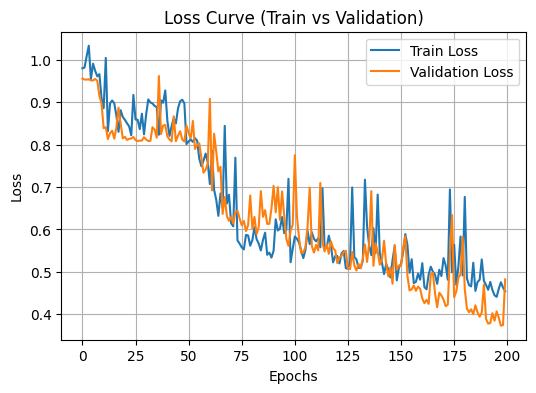

In [16]:
# =============================================
# ====== 10. Final Training with Loss Curve ======
# =============================================
train_idx, val_idx = train_test_split(trainval_idx, test_size=0.2, random_state=seed)
final_loader = DataLoader(Subset(dataset, trainval_idx), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)

final_model = CNN2D().to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_losses = []
val_losses   = []

print("\n=== Final Training on Full Train+Val Set ===")
for epoch in range(1, epochs + 1):
    final_model.train()
    epoch_loss = 0.0
    for xb, yb in final_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(final_model(xb), yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(final_loader))

    # Validation loss
    final_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = final_model(xb)
            val_loss += criterion(preds, yb).item()
    val_losses.append(val_loss / len(val_loader))

    if epoch % 10 == 0 or epoch == epochs:
        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

# Plot Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curve (Train vs Validation)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# =============================================
# ====== 11. Final Evaluation (Train/Val/Test) ======
# =============================================
def evaluate(model, loader, scaler):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            preds = model(xb.to(device)).cpu().numpy()
            yb_np = yb.cpu().numpy()
            preds_orig = scaler.inverse_transform(preds)
            yb_orig = scaler.inverse_transform(yb_np)
            y_true.append(yb_orig)
            y_pred.append(preds_orig)
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    return y_true, y_pred


train_true, train_pred = evaluate(final_model, final_loader, y_scaler)
val_true, val_pred     = evaluate(final_model, val_loader, y_scaler)
test_true, test_pred   = evaluate(final_model, test_loader, y_scaler)

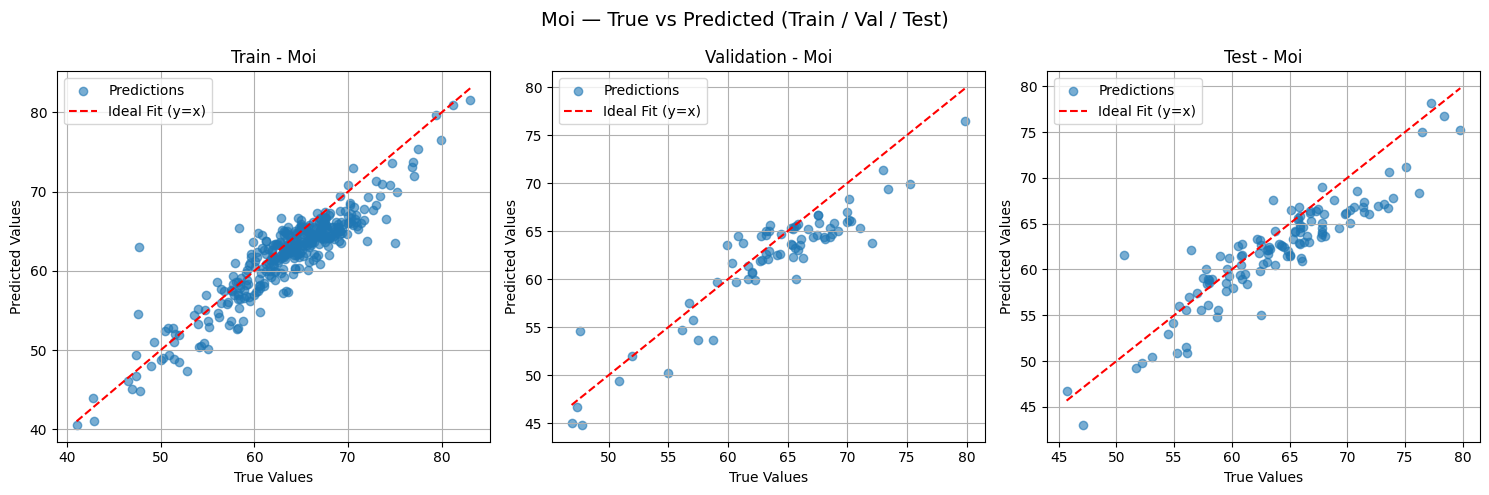

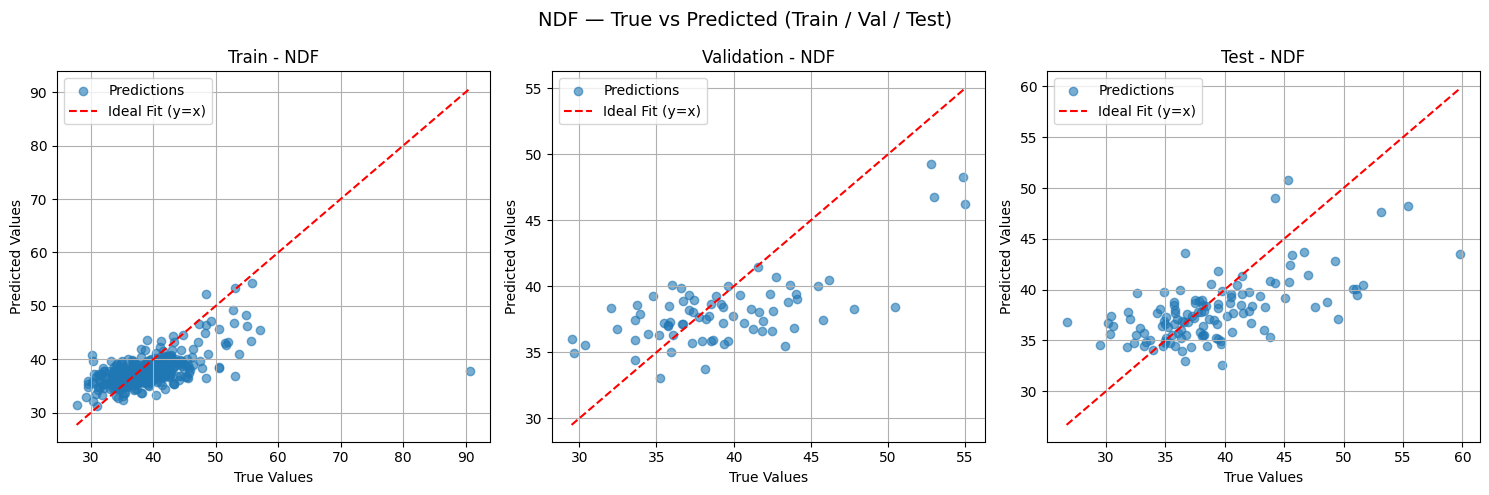

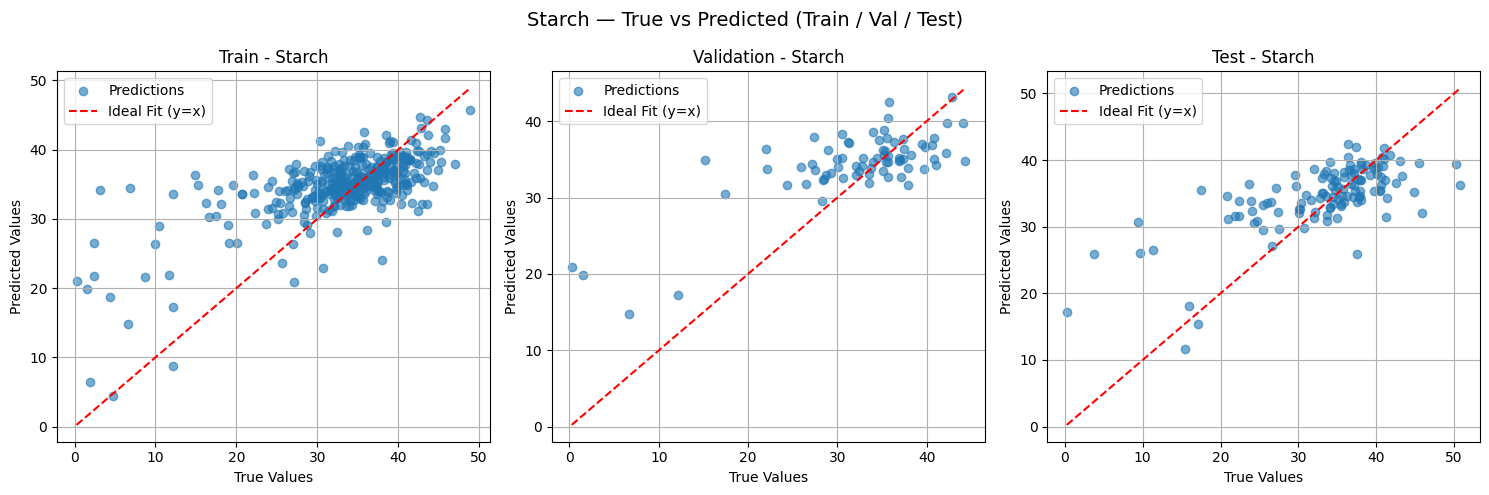

In [18]:
# =============================================
# ====== 12. Plot All Targets (Train/Val/Test) ======
# =============================================
for i, t in enumerate(TARGETS):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    datasets = [("Train", train_true, train_pred),
                ("Validation", val_true, val_pred),
                ("Test", test_true, test_pred)]

    for ax, (name, y_true, y_pred) in zip(axes, datasets):
        ax.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, label="Predictions")
        min_val, max_val = y_true[:, i].min(), y_true[:, i].max()
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit (y=x)")
        ax.set_xlabel("True Values")
        ax.set_ylabel("Predicted Values")
        ax.set_title(f"{name} - {t}")
        ax.legend()
        ax.grid(True)

    plt.suptitle(f"{t} — True vs Predicted (Train / Val / Test)", fontsize=14)
    plt.tight_layout()
    plt.show()

In [19]:
# =============================================
# ====== 13. Compute and Print Metrics ======
# =============================================
def print_metrics(name, y_true, y_pred):
    metrics = compute_metrics_orig(y_true, y_pred)
    print(f"\n📊 {name} Results:")
    for i, t in enumerate(TARGETS):
        rmse = metrics[i]['RMSE']
        r2   = metrics[i]['R2']
        bias = metrics[i]['Bias']
        print(f"🎯 {t}: R²: {r2:.4f}  RMSE: {rmse:.4f}  Bias: {bias:.4f")
print_metrics("Train", train_true, train_pred)
print_metrics("Validation", val_true, val_pred)
print_metrics("Test", test_true, test_pred)



📊 Train Results:
🎯 Moi:
    RMSE: 2.873
    R²: 0.782
    Bias: -1.517
🎯 NDF:
    RMSE: 4.831
    R²: 0.317
    Bias: -1.057
🎯 Starch:
    RMSE: 6.345
    R²: 0.415
    Bias: 1.689

📊 Validation Results:
🎯 Moi:
    RMSE: 2.934
    R²: 0.784
    Bias: -1.606
🎯 NDF:
    RMSE: 4.159
    R²: 0.400
    Bias: -1.271
🎯 Starch:
    RMSE: 6.338
    R²: 0.463
    Bias: 2.214

📊 Test Results:
🎯 Moi:
    RMSE: 3.127
    R²: 0.750
    Bias: -1.710
🎯 NDF:
    RMSE: 4.570
    R²: 0.338
    Bias: -1.074
🎯 Starch:
    RMSE: 6.458
    R²: 0.440
    Bias: 1.425


In [ ]:
# =============================================
# ====== 14. Save Final Model ======
# =============================================
file_path = f"/content/{base}.pth"
torch.save(final_model.state_dict(), file_path)
print(f"\n✅ Model saved to: {file_path}")

In [20]:
# =============================================
# ====== 15. Targets Info ======
# =============================================
for target in TARGETS:
    print(f"{target}: Min={df[target].min():.3f}, Max={df[target].max():.3f}")

Moi: Min=41.001, Max=83.060
NDF: Min=26.690, Max=90.740
Starch: Min=0.250, Max=50.800
